# Meat Price Forecast

#### Key features
- `Goods and services`: Meat type
- `Aimag`: Ulaanbaatar
- `Meat price value`: Meat price per kg


In this problem, based on the meat price data of 2010 to 2021, taken from 1212.mn. Mutton and beef price has been increasing. Therefore, using FbProphet, I will try to predict each meat price per kg for the next 12 months

### Importing libraries and data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px
import numpy as np
import datetime
from prophet import Prophet
from prophet.plot import plot_yearly
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] =  (10, 6)

##### Changed the original name of data to meat price data since it was confusing

In [3]:
df = pd.read_csv('meat price data.csv',thousands=',')

In [4]:
df

,Goods and services,Aimag,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,...,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
0,"Beef, with bones, kg",Ulaanbaatar,4060,4800,4800,4405,4235,4665,4785,4915,...,12640,12758,11751,11237,10684,11074,11208,11614,12606,12666
1,"Mutton, with bones, kg",Ulaanbaatar,3710,4205,4250,3810,3610,4105,4040,4244,...,10385,10648,9864,9169,8551,8632,8579,9034,10459,10692


In [5]:
df.shape

(2, 126)

##### Dropping unnecessary columns and converting to long form data

In [6]:
df = df.drop(["Aimag"],axis=1)

In [7]:
df = pd.melt(df, id_vars = "Goods and services")

In [8]:
grouped = df.groupby(df['Goods and services'])

In [9]:
mutton = grouped.get_group("Mutton, with bones, kg")
beef = grouped.get_group("Beef, with bones, kg")

In [10]:
mutton = mutton.rename(columns={'value': 'mutton', 'variable': 'date'})
beef = beef.rename(columns={'value': 'beef', 'variable': 'date'})

In [11]:
mutton = mutton.drop(["Goods and services"], axis = 1)
beef = beef.drop(["Goods and services"], axis = 1)

In [12]:
beef

,date,beef
0,2010-12,4060.00000
2,2011-01,4800.00000
4,2011-02,4800.00000
6,2011-03,4405.00000
8,2011-04,4235.00000
...,...,...
238,2020-11,11074.00000
240,2020-12,11208.00000
242,2021-01,11614.00000
244,2021-02,12606.00000


In [13]:
df = pd.merge(mutton, beef)

In [14]:
df.dtypes

date       object
mutton    float64
beef      float64
dtype: object

##### Since prophet only accepts pd.datetime series, converted date to dt series

In [15]:
df['date'] = pd.to_datetime(df['date'])
mutton['date'] = pd.to_datetime(mutton['date'])
beef['date'] = pd.to_datetime(beef['date'])

In [16]:
mutton = mutton.rename(columns={'mutton': 'y', 'date': 'ds'})
beef = beef.rename(columns={'beef': 'y', 'date': 'ds'})

### EDA

In [17]:
df.describe()

,mutton,beef
count,124.00000,124.00000
mean,6890.80645,8100.33266
std,1676.22546,2021.46679
min,3610.00000,4060.00000
25%,5959.50000,7114.75000
50%,6901.00000,7882.00000
75%,7570.00000,8696.25000
max,10692.00000,12758.00000


##### Max price of mutton and beef has around 2000 tugriks difference while the both minimum was around 3600 to 4000 tugriks

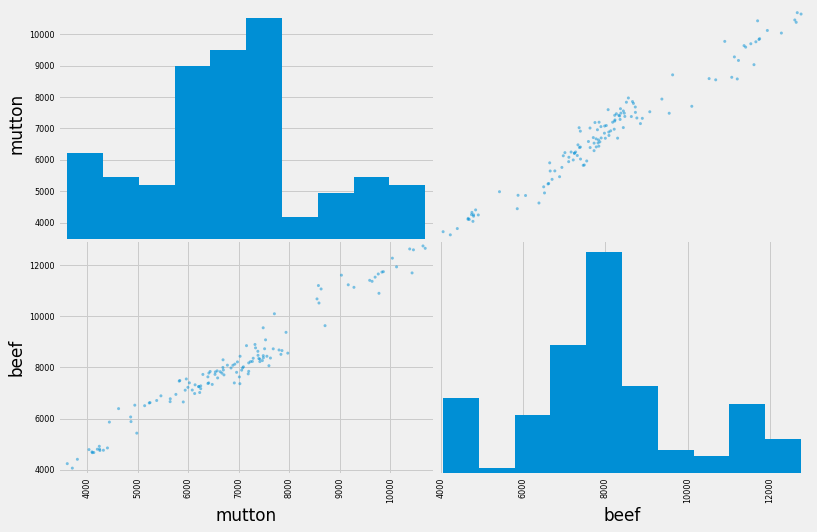

In [18]:
pd.plotting.scatter_matrix(df, figsize=(12,8))
plt.show()

#### Mutton data

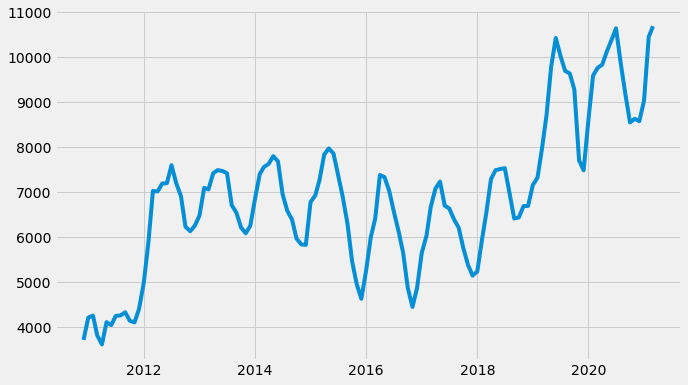

In [19]:
plt.plot(df['date'],df['mutton'])

#### Beef data

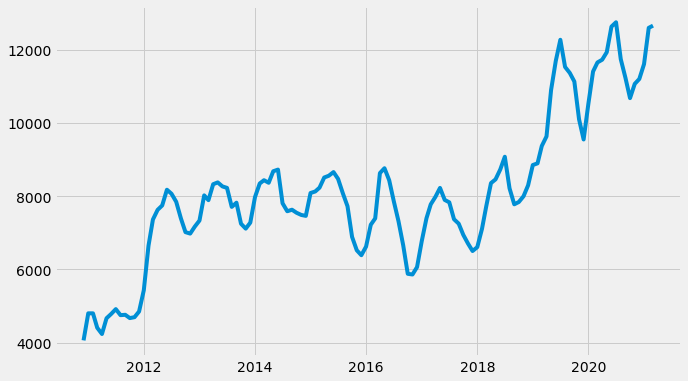

In [20]:
plt.plot(df['date'],df['beef'])

#### Average mutton price for each month over the years

In [21]:
months = df.groupby(df['date'].dt.month).mean()['mutton']

Text(0, 0.5, 'Mutton price')

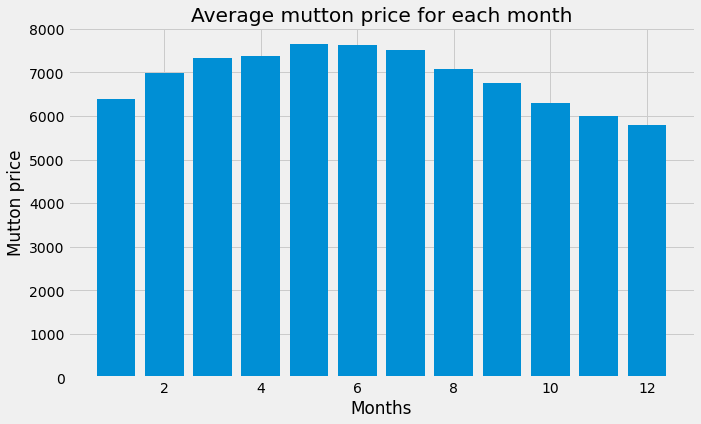

In [22]:
plt.bar(months.index, months)
plt.title('Average mutton price for each month')
plt.xlabel('Months')
plt.ylabel('Mutton price')

##### april to june is highest price for mutton meat 

#### Average beef price for each month over the years

In [23]:
months_beef = df.groupby(df['date'].dt.month).mean()['beef']

Text(0, 0.5, 'Beef price')

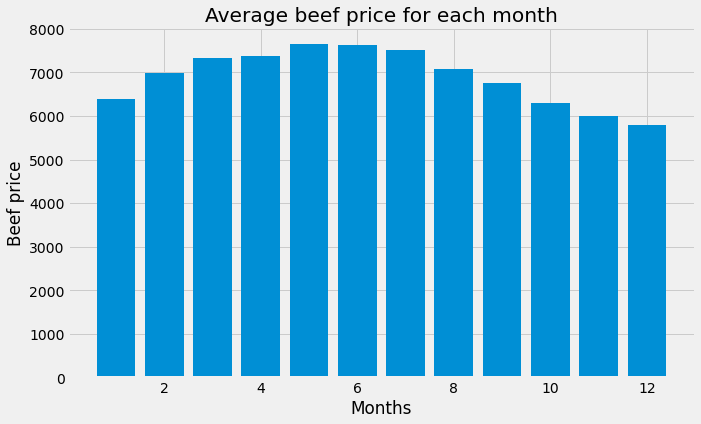

In [24]:
plt.bar(months.index, months)
plt.title('Average beef price for each month')
plt.xlabel('Months')
plt.ylabel('Beef price')

##### Similar to mutton beef price is higher during the months of summer and spring

#### Average mutton price in each year

In [25]:
years = df.groupby(df['date'].dt.year).mean()['mutton']

Text(0, 0.5, 'Average price')

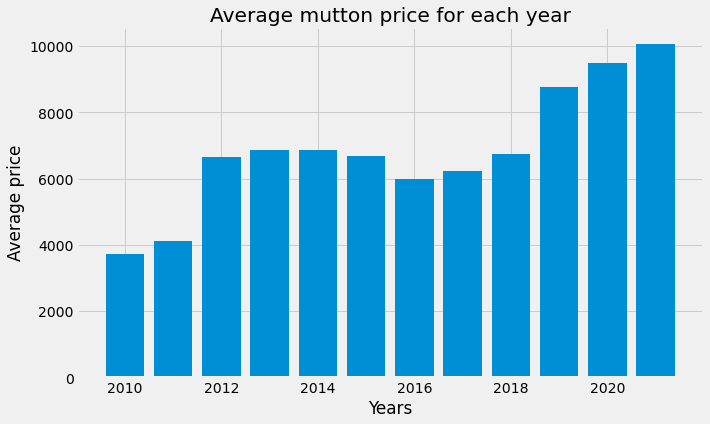

In [26]:
plt.bar(years.index, years)
plt.title('Average mutton price for each year')
plt.xlabel('Years')
plt.ylabel('Average price')

#### Average beef price for each year

In [27]:
years_beef = df.groupby(df['date'].dt.year).mean()['beef']

Text(0, 0.5, 'Average price')

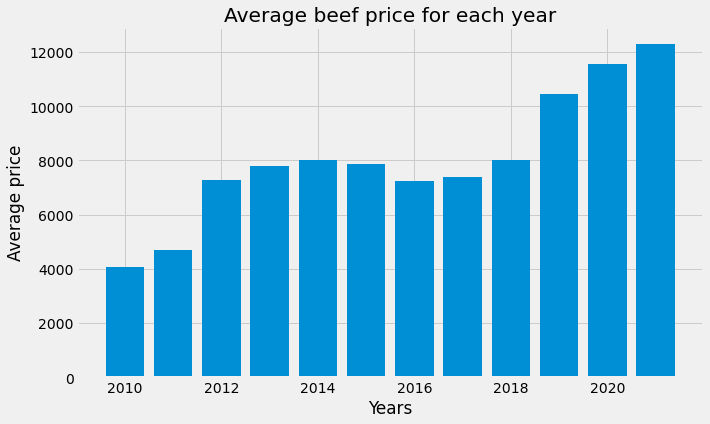

In [28]:
plt.bar(years_beef.index, years_beef)
plt.title('Average beef price for each year')
plt.xlabel('Years')
plt.ylabel('Average price')

### Prophet fitting

In [29]:
m = Prophet()
m.fit(mutton)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast

##### Mutton data forecast by 12 months 

In [30]:
future = m.make_future_dataframe(periods=12, freq='M')

In [31]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-12-01,3037.60460,2320.19472,3761.61841
1,2011-01-01,3733.37564,3018.48451,4430.49338
2,2011-02-01,4409.48868,3668.46295,5099.60612
3,2011-03-01,4629.70645,3966.54607,5323.07354
4,2011-04-01,5078.66686,4415.18316,5786.98731
...,...,...,...,...
131,2021-10-31,9780.93274,9069.27645,10471.27432
132,2021-11-30,9851.51304,9129.21344,10525.02845
133,2021-12-31,10972.80493,10286.76743,11690.58332
134,2022-01-31,11704.39059,11024.06146,12391.77630


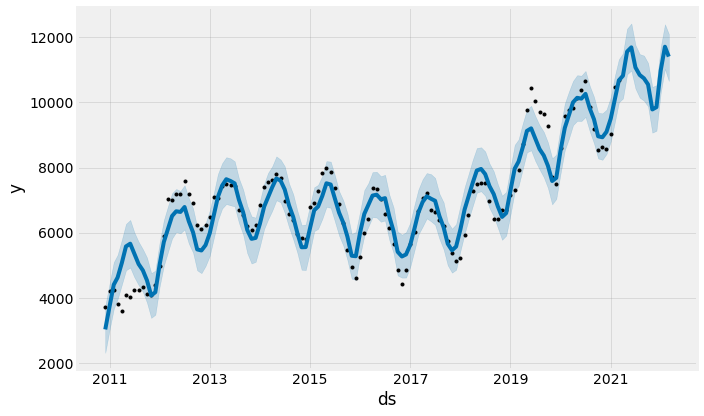

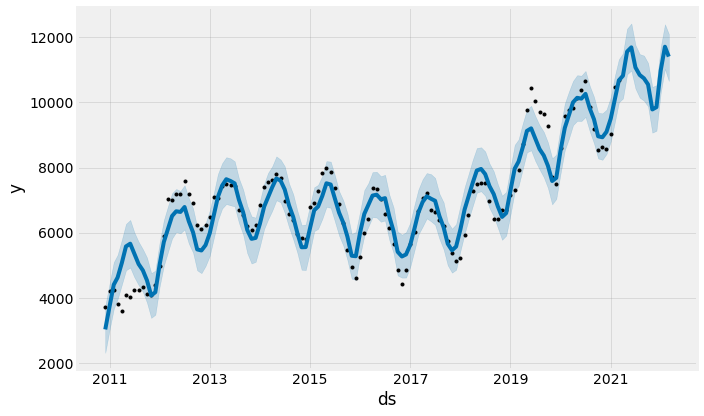

In [32]:
m.plot(forecast)

##### Plot components

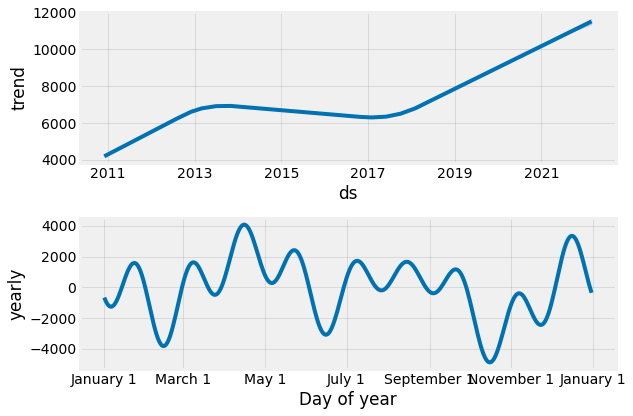

In [33]:
fig = m.plot_components(forecast)

##### Mutton data with multiplicative seasonality

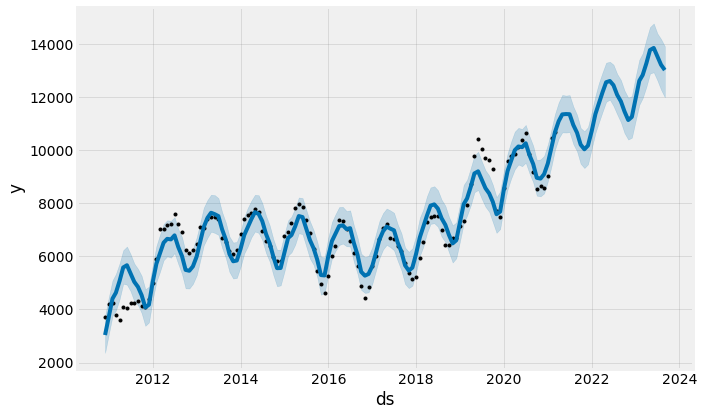

In [34]:
future = m.make_future_dataframe(30, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

##### Mutton forecast by each day for the next 365 days

In [35]:
future_day = m.make_future_dataframe(periods=365)

In [36]:
forecast1 = m.predict(future_day)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-12-01,3037.60460,2359.28929,3734.33368
1,2011-01-01,3733.37564,2993.83317,4397.18918
2,2011-02-01,4409.48868,3699.09418,5162.50088
3,2011-03-01,4629.70645,3964.67874,5317.98216
4,2011-04-01,5078.66686,4395.79802,5790.09285
...,...,...,...,...
484,2022-02-25,10254.25847,9572.93924,10904.22205
485,2022-02-26,10645.63484,9950.99149,11357.51390
486,2022-02-27,11030.56215,10299.87599,11789.66194
487,2022-02-28,11401.27407,10709.04374,12124.60156


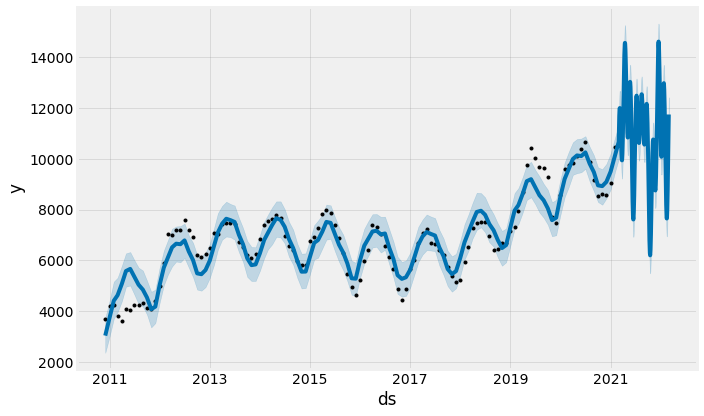

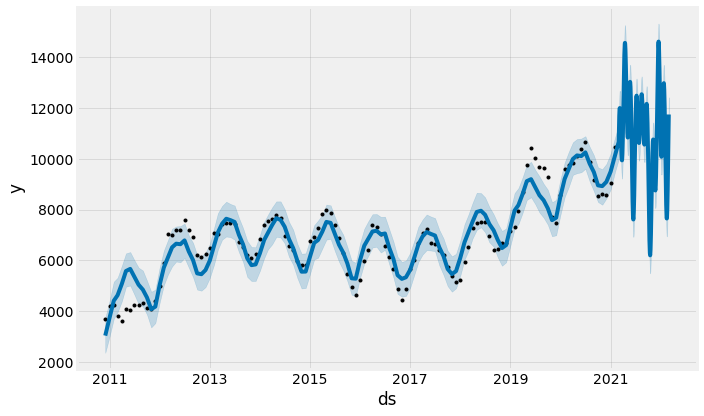

In [37]:
m.plot(forecast1)

##### Since the original data is monthly given, forecast made for everyday is inaccurate becasue it lacks historical data

### Beef data

In [38]:
m = Prophet()
m.fit(beef)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
future = m.make_future_dataframe(periods=12, freq='M')

In [40]:
forecast_beef = m.predict(future)
forecast_beef[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-12-01,3469.30748,2836.03077,4105.69742
1,2011-01-01,4118.54667,3423.99601,4791.06193
2,2011-02-01,4762.53801,4097.09701,5391.48562
3,2011-03-01,4989.18708,4359.61780,5657.52963
4,2011-04-01,5213.00766,4570.12393,5824.08819
...,...,...,...,...
131,2021-10-31,12611.30815,11973.72349,13266.89257
132,2021-11-30,12655.93685,11981.51197,13284.71402
133,2021-12-31,13728.71802,13098.06506,14368.67922
134,2022-01-31,14613.50550,13974.66270,15225.09728


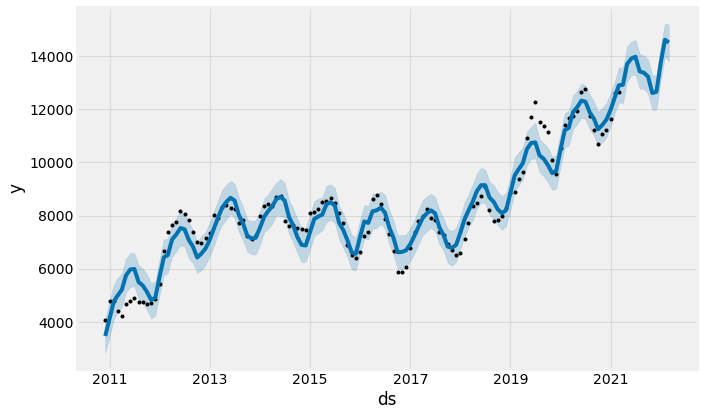

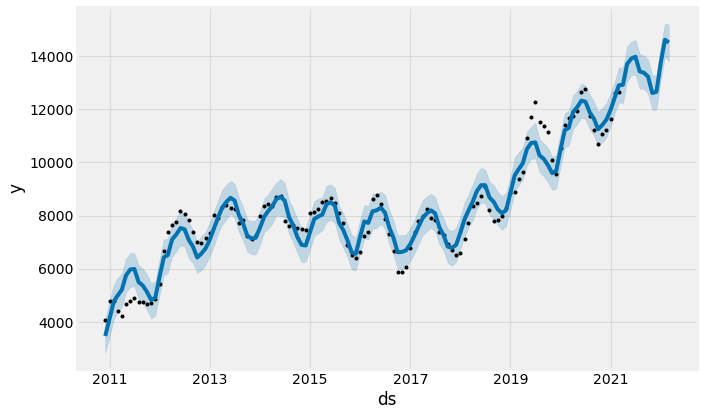

In [41]:
m.plot(forecast_beef)

##### Plot components

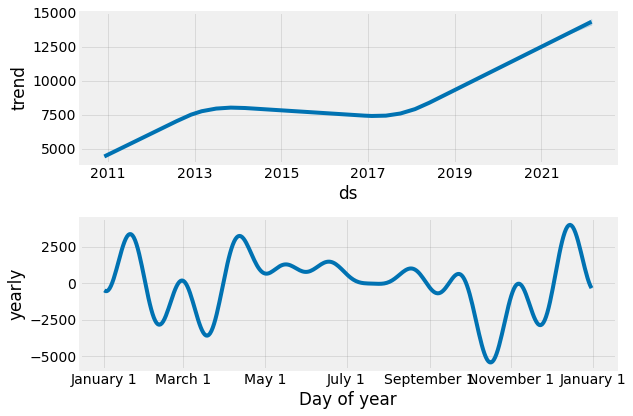

In [42]:
fig = m.plot_components(forecast_beef)

##### Combining the graphs

In [43]:
forecast = forecast.rename(columns={'yhat': 'mutton'})
forecast_beef = forecast_beef.rename(columns={'yhat': 'beef'})

In [44]:
Total_forecast = pd.DataFrame()

In [45]:
Total_forecast['date'] = forecast_beef['ds']
Total_forecast['beef'] = forecast_beef['beef']
Total_forecast['mutton'] = forecast['mutton']

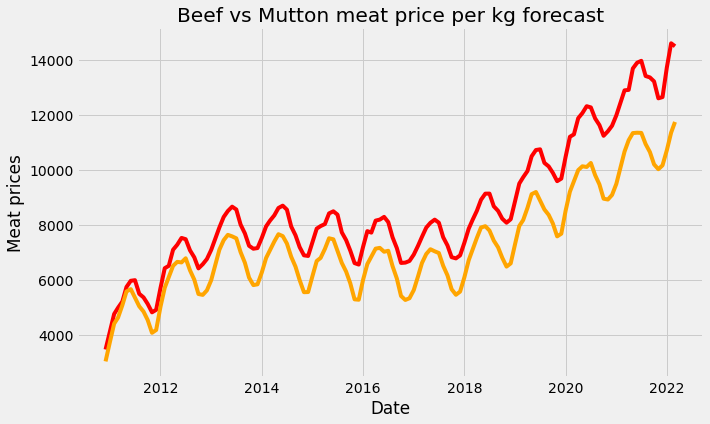

In [46]:
plt.plot(Total_forecast['date'], Total_forecast['beef'], color='red')
plt.plot(Total_forecast['date'], Total_forecast['mutton'], color='orange')
plt.xlabel('Date')
plt.ylabel('Meat prices')
plt.title('Beef vs Mutton meat price per kg forecast')
plt.show()

##### As we can see, Beef price is slightly higer over the years and even forecast shows that the beef price will increase more than mutton price in the upcoming 12 months